In [42]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import collections
import community.community_louvain as community_louvain
from mpl_toolkits.mplot3d import Axes3D
import pyvis
import random
from statistics import median

In [2]:
# !pip install community
# !pip install networkx
# !pip install python-louvain

---

### Import & prepare data

In [3]:
data = pd.read_csv("./Data/student_all.csv")

In [4]:
data.rename(columns={"sex":"gender"}, inplace=True)

In [5]:
data.drop(columns='Unnamed: 0', inplace=True)

In [6]:
data['alc'] = data['Dalc'] + data['Walc']

In [7]:
indexes = [i for i in range(data.shape[0])]
indexes = pd.DataFrame({"Names":indexes})
indexes
data = pd.concat([data, indexes], axis=1)

In [8]:
data["guardian"][data["guardian"] == "father"] = "parent"
data["guardian"][data["guardian"] == "mother"] = "parent"

C:\Users\Marin\AppData\Local\Temp/ipykernel_14096/3828257580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["guardian"][data["guardian"] == "father"] = "parent"
C:\Users\Marin\AppData\Local\Temp/ipykernel_14096/3828257580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["guardian"][data["guardian"] == "mother"] = "parent"


In [9]:
data['absences'][(data["absences"] > 0) & (data["absences"] < 11)] = 1

C:\Users\Marin\AppData\Local\Temp/ipykernel_14096/2866260647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['absences'][(data["absences"] > 0) & (data["absences"] < 11)] = 1


In [10]:
data["guardian"].unique()

array(['parent', 'other'], dtype=object)

In [11]:
data.head(10)

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,G3,course,alc,Names
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,1,1,3,1,5,6,6,mat,2,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,1,3,1,5,5,6,mat,2,1
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,3,3,1,7,8,10,mat,5,2
3,GP,F,15,U,GT3,T,4,2,health,services,...,1,1,5,1,15,14,15,mat,2,3
4,GP,F,16,U,GT3,T,3,3,other,other,...,1,2,5,1,6,10,10,mat,3,4
5,GP,M,16,U,LE3,T,4,3,services,other,...,1,2,5,1,15,15,15,mat,3,5
6,GP,M,16,U,LE3,T,2,2,other,other,...,1,1,3,0,12,12,11,mat,2,6
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,1,1,1,1,6,5,6,mat,2,7
8,GP,M,15,U,LE3,A,3,2,services,other,...,1,1,1,0,16,18,19,mat,2,8
9,GP,M,15,U,GT3,T,3,4,other,other,...,1,1,5,0,14,15,15,mat,2,9


In [12]:
data.tail(10)

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,G3,course,alc,Names
1036,MS,F,18,R,GT3,T,2,2,at_home,other,...,1,3,4,0,14,17,15,por,4,1036
1037,MS,F,17,U,GT3,T,4,3,teacher,other,...,1,1,1,0,6,9,11,por,2,1037
1038,MS,F,18,R,GT3,T,4,4,teacher,at_home,...,2,2,5,1,7,9,10,por,4,1038
1039,MS,F,19,R,GT3,T,2,3,services,other,...,1,2,5,1,10,11,10,por,3,1039
1040,MS,F,18,U,LE3,T,3,1,teacher,services,...,1,1,1,1,15,15,16,por,2,1040
1041,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,5,1,11,12,9,por,2,1041
1042,MS,M,17,U,LE3,T,3,1,services,services,...,3,4,2,1,10,10,10,por,7,1042
1043,MS,M,18,R,LE3,T,3,2,services,other,...,3,4,5,1,10,11,11,por,7,1043
1044,UN,M,23,U,GT3,T,4,4,other,other,...,2,4,4,1,12,15,13,mat,6,1044
1045,UN,F,22,U,LE3,T,3,3,teacher,teacher,...,2,3,3,15,13,16,14,mat,5,1045


In [13]:
data.shape

(1046, 36)

In [14]:
data.columns

Index(['school', 'gender', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'course', 'alc',
       'Names'],
      dtype='object')

---

### Prepare data for graph

In [15]:
# To install a package in a Jupyter Notebook
# !pip install *package name*

In [16]:
data_vec = data.to_numpy()

In [17]:
data_vec.shape

(1046, 36)

In [18]:
data_vec

array([['GP', 'F', 18, ..., 'mat', 2, 0],
       ['GP', 'F', 17, ..., 'mat', 2, 1],
       ['GP', 'F', 15, ..., 'mat', 5, 2],
       ...,
       ['MS', 'M', 18, ..., 'por', 7, 1043],
       ['UN', 'M', 23, ..., 'mat', 6, 1044],
       ['UN', 'F', 22, ..., 'mat', 5, 1045]], dtype=object)

In [19]:
data_vec[1, :]

array(['GP', 'F', 17, 'U', 'GT3', 'T', 1, 1, 'at_home', 'other', 'course',
       'parent', 1, 2, 0, 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes',
       'no', 5, 3, 3, 1, 1, 3, 1, 5, 5, 6, 'mat', 2, 1], dtype=object)

In [20]:
data_vec[1, 1] == data_vec[1, 1]

True

In [21]:
data_vec.shapeb

(1046, 36)

---

### Grapg creation

In [22]:
G = nx.Graph()

In [23]:
# TODO: Define a threshold
# lim -> 0 similare
# lim -> infinite different
list_of_scores = []
for vec in range(1, data_vec.shape[0]):
    for vecs in range(data_vec.shape[0]):
        list_difference = []
        for col in range(data_vec.shape[1]):
            list_difference.append(data_vec[vec - 1, col-1] != data_vec[vecs, col-1])
            diff_score = sum(list_difference)
            list_of_scores.append(diff_score)
        if diff_score < 9:
            G.add_edge(data_vec[vec, -1], data_vec[vecs, -1])
        else: 
            pass

In [24]:
print(f"Len: {len(list_of_scores)}")
print(f"Mean: {round(np.mean(list_of_scores), 4)}")
print(f"Median: {np.median(list_of_scores)}")
print(f"Max: {np.max(list_of_scores)}")
print(f"Min: {np.min(list_of_scores)}")

Len: 39350520
Mean: 9.9017
Median: 9.0
Max: 34
Min: 0


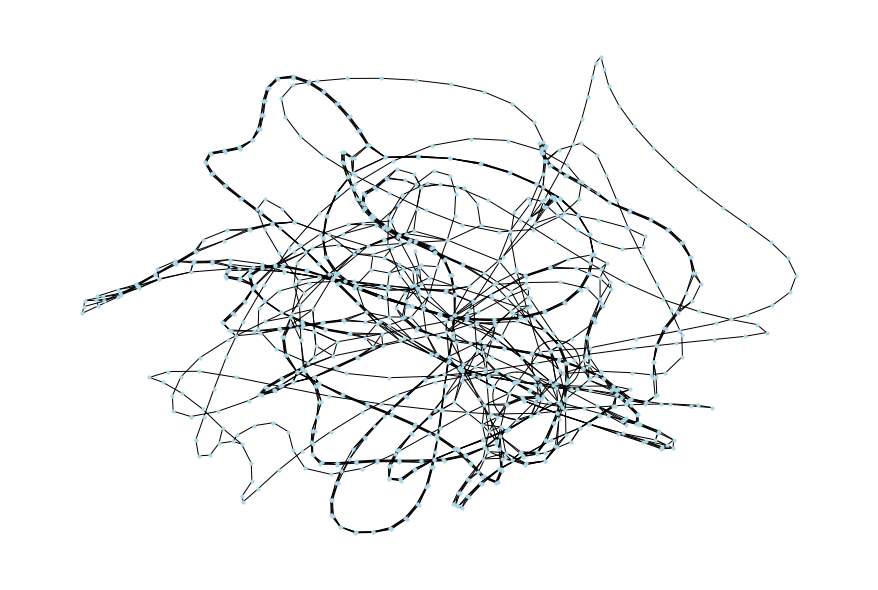

In [23]:
plt.figure(figsize=(12, 8))
graph_options = {
    'node_color': 'lightblue',
    'node_size' : 10,
    "edge_color": 'black'
}

nx.draw(G, **graph_options)
plt.show()

First weighting attempt

In [24]:
weighting = {'school': 1,
             'gender':1.5,
             'age':0.5,
             'address':1,
             'famsize':0.5,
             'Pstatus':1.5,
             'Medu':1,
             'Fedu':1,
             'Mjob':1.5,
             'Fjob':1.5,
             'reason':0.5,
             'guardian':1,
             'traveltime':0.5,
             'studytime':1,
             'failures':1,
             'schoolsup':1,
             'famsup':1,
             'paid':0.5,
             'activities':1,
             'nursery':0.5,
             'higher':0.5,
             'internet':1.5,
             'romantic':1,
             'famrel':1.5,
             'freetime':0.5,
             'goout':1,
             'Dalc':1.5,
             'Walc':1.5,
             'health':1,
             'absences':1,
             'G1':0.5,
             'G2':0.5,
             'G3':0.5,
             'course':0.5,
             'alc':1.5,
             'Names':0
            }


Random based weighting

In [33]:
weights = {key:random.uniform(0, 2) for key in list(data.columns)}
weights

{'school': 0.127573487242703,
 'gender': 1.6725024961854424,
 'age': 0.5937482024893557,
 'address': 1.3746047101187904,
 'famsize': 0.1450347311708826,
 'Pstatus': 1.9456433678015437,
 'Medu': 0.7682594263822016,
 'Fedu': 0.6758089837253236,
 'Mjob': 1.2893838886921918,
 'Fjob': 1.7742673850601776,
 'reason': 0.682663932873766,
 'guardian': 0.19193485357101836,
 'traveltime': 0.7169382659121861,
 'studytime': 0.9968447893877579,
 'failures': 1.6359775657087525,
 'schoolsup': 1.3429275381594865,
 'famsup': 1.529546672747254,
 'paid': 1.4410112182315946,
 'activities': 1.7521332748675384,
 'nursery': 1.9902415732411916,
 'higher': 1.5797179905259702,
 'internet': 1.5959963132188653,
 'romantic': 0.5251354080619861,
 'famrel': 1.0106015978615999,
 'freetime': 0.25404572358188293,
 'goout': 0.41381046091614415,
 'Dalc': 1.006290037057194,
 'Walc': 0.7664821186754733,
 'health': 0.34997767554613857,
 'absences': 0.43186286863750434,
 'G1': 1.7719421306288705,
 'G2': 0.7274042084018055,
 'G

---

Main cell to create the graph: 

Can be upgrade as a function

In [98]:
data_vec[-1, -1]

1045

In [25]:
# Change weighting by weight 
columns_name = list(data.columns)
list_of_scores = []
for vec in range(1, data_vec.shape[0]):
    for vecs in range(data_vec.shape[0]):
        list_difference = []
        score = 0
        for col in range(data_vec.shape[1]):
            if data_vec[vec - 1, col-1] != data_vec[vecs, col-1]:
                score += weighting[columns_name[col]]
                list_of_scores.append(score)
        
        if score < 10.5:
            G.add_edge(data_vec[vec, -1], data_vec[vecs, -1])
        else: 
            pass


---

First plot attempt

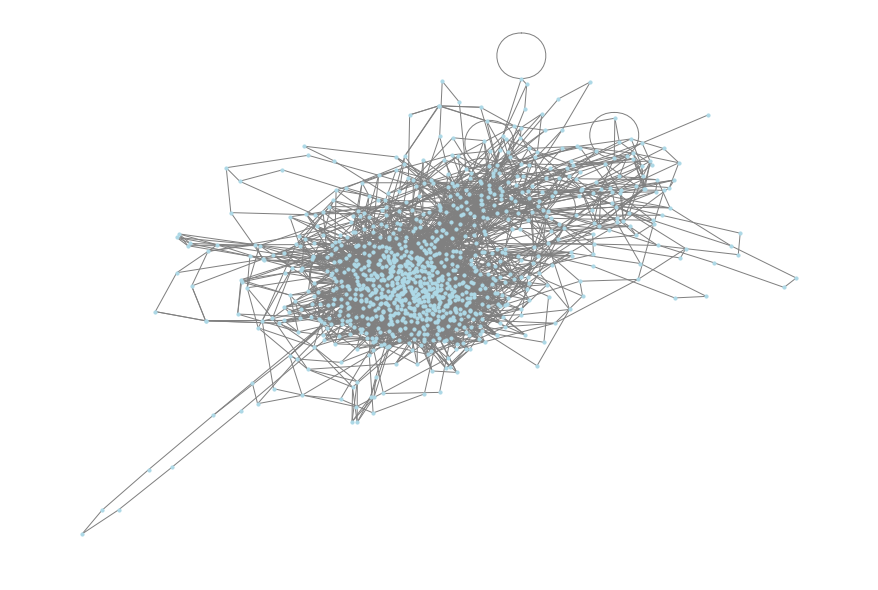

In [26]:
plt.figure(figsize=(12, 8))
graph_options = {
    'node_color': 'lightblue',
    'node_size' : 10,
    "edge_color": 'grey'
}

nx.draw(G, **graph_options, label=True)
plt.show()

---

Compute basic statistics on the score list

In [27]:
print(f"Len: {len(list_of_scores)}")
print(f"Mean: {round(np.mean(list_of_scores), 4)}")
print(f"Median: {np.median(list_of_scores)}")
print(f"Max: {np.max(list_of_scores)}")
print(f"Min: {np.min(list_of_scores)}")

Len: 22184068
Mean: 10.7434
Median: 10.5
Max: 32.5
Min: 1.0


In [99]:
G.number_of_nodes()

1046

In [100]:
G.number_of_edges()

5881

List all self_loops

In [112]:
list(nx.selfloop_edges(G))

[]

In [111]:
G.remove_edges_from(nx.selfloop_edges(G))

---

### Louvain partitioning

In [84]:
partition = community_louvain.best_partition(G)
len(partition)

1046

---

Plot with partitions

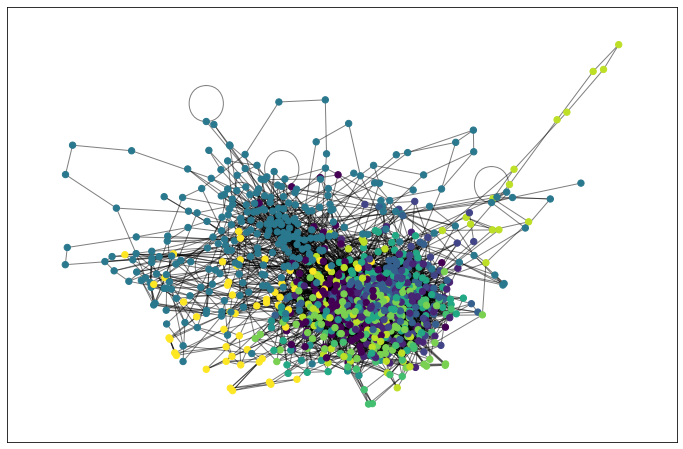

In [29]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

---

In [30]:
set(partition.values())
# Donc il y a 11 communautés ?

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

---

Compute modularity of the Louvain partitioning

In [48]:
def louvain_community_quality(G, communities):
    """
    Calculate the quality of a Louvain community detection using the modularity score.
    
    Parameters:
    - G: NetworkX graph
    - communities: list of sets, representing the detected communities
    
    Returns:
    - modularity: float, the modularity score
    """
    # Calculate the modularity score
    modularity = nx.algorithms.community.modularity(G, communities)
    
    return modularity

The 2 next cells modify the partition variable form from a dict to a list of sets containing each node and each set are a community.

In [63]:
from collections import defaultdict
sets = defaultdict(set)

# Iterate through the dictionary and add each key to the set with the corresponding value
for key, value in partition.items():
    sets[value].add(key)

In [73]:
part_by_com = [sets[x] for x in list(sets.keys())]
part_by_com

[{0,
  1,
  2,
  79,
  80,
  190,
  191,
  192,
  193,
  205,
  206,
  207,
  208,
  218,
  219,
  220,
  221,
  222,
  223,
  239,
  240,
  260,
  261,
  262,
  263,
  264,
  265,
  286,
  287,
  288,
  289,
  290,
  316,
  317,
  318,
  332,
  344,
  345,
  346,
  347,
  395,
  396,
  397,
  398,
  428,
  474,
  475,
  536,
  537,
  598,
  599,
  600,
  601,
  602,
  614,
  615,
  616,
  617,
  618,
  627,
  628,
  629,
  630,
  631,
  632,
  657,
  658,
  659,
  660,
  695,
  696,
  697,
  698,
  699,
  700,
  728,
  729,
  730,
  731,
  732,
  749,
  750,
  755,
  756,
  781,
  793,
  794,
  795,
  796,
  817,
  818},
 {3,
  4,
  34,
  35,
  70,
  71,
  72,
  77,
  78,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  99,
  100,
  106,
  107,
  125,
  167,
  168,
  169,
  182,
  194,
  195,
  209,
  210,
  211,
  212,
  267,
  268,
  291,
  292,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  303,
  304,
  348,
  349,
  472,
  473,
  482,
  483,
  484,
  485,
  486,
  487

In [74]:
louvain_community_quality(G, part_by_com)

0.45970266835917406

---

In [31]:
partition_sort = collections.OrderedDict(sorted(partition.items()))
partition_sort

OrderedDict([(0, 1),
             (1, 0),
             (2, 0),
             (3, 2),
             (4, 1),
             (5, 1),
             (6, 1),
             (7, 1),
             (8, 1),
             (9, 3),
             (10, 3),
             (11, 3),
             (12, 3),
             (13, 6),
             (14, 6),
             (15, 1),
             (16, 1),
             (17, 1),
             (18, 1),
             (19, 1),
             (20, 3),
             (21, 3),
             (22, 3),
             (23, 3),
             (24, 3),
             (25, 3),
             (26, 0),
             (27, 0),
             (28, 6),
             (29, 6),
             (30, 3),
             (31, 3),
             (32, 3),
             (33, 3),
             (34, 6),
             (35, 6),
             (36, 6),
             (37, 6),
             (38, 3),
             (39, 3),
             (40, 5),
             (41, 5),
             (42, 3),
             (43, 3),
             (44, 6),
             (45, 6)

---

### Add communities in the dataframe

In [32]:
partition_sorted = dict(sorted(partition.items()))
partition_sorted

{0: 1,
 1: 0,
 2: 0,
 3: 2,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 3,
 10: 3,
 11: 3,
 12: 3,
 13: 6,
 14: 6,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 3,
 21: 3,
 22: 3,
 23: 3,
 24: 3,
 25: 3,
 26: 0,
 27: 0,
 28: 6,
 29: 6,
 30: 3,
 31: 3,
 32: 3,
 33: 3,
 34: 6,
 35: 6,
 36: 6,
 37: 6,
 38: 3,
 39: 3,
 40: 5,
 41: 5,
 42: 3,
 43: 3,
 44: 6,
 45: 6,
 46: 6,
 47: 6,
 48: 6,
 49: 6,
 50: 0,
 51: 0,
 52: 0,
 53: 3,
 54: 3,
 55: 3,
 56: 3,
 57: 3,
 58: 3,
 59: 0,
 60: 0,
 61: 7,
 62: 7,
 63: 7,
 64: 7,
 65: 7,
 66: 7,
 67: 7,
 68: 7,
 69: 7,
 70: 8,
 71: 8,
 72: 8,
 73: 6,
 74: 6,
 75: 6,
 76: 6,
 77: 8,
 78: 8,
 79: 8,
 80: 8,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 8,
 86: 8,
 87: 8,
 88: 8,
 89: 8,
 90: 8,
 91: 8,
 92: 8,
 93: 8,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 3,
 102: 3,
 103: 3,
 104: 3,
 105: 3,
 106: 1,
 107: 6,
 108: 6,
 109: 2,
 110: 2,
 111: 2,
 112: 2,
 113: 2,
 114: 2,
 115: 3,
 116: 3,
 117: 6,
 118: 6,
 119: 6,
 120: 0,
 121: 0,
 122: 0,
 12

In [33]:
partition_sorted = pd.DataFrame.from_dict(partition_sorted, orient="index")

In [34]:
partition_sorted

,0
0,1
1,0
2,0
3,2
4,1
...,...
1041,4
1042,4
1043,4
1044,4


In [35]:
data = pd.concat([data, partition_sorted], axis=1)

In [36]:
data

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Walc,health,absences,G1,G2,G3,course,alc,Names,0
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,1,3,1,5,6,6,mat,2,0,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,3,1,5,5,6,mat,2,1,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,3,1,7,8,10,mat,5,2,0
3,GP,F,15,U,GT3,T,4,2,health,services,...,1,5,1,15,14,15,mat,2,3,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,5,1,6,10,10,mat,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,MS,F,18,U,GT3,T,1,1,other,other,...,1,5,1,11,12,9,por,2,1041,4
1042,MS,M,17,U,LE3,T,3,1,services,services,...,4,2,1,10,10,10,por,7,1042,4
1043,MS,M,18,R,LE3,T,3,2,services,other,...,4,5,1,10,11,11,por,7,1043,4
1044,UN,M,23,U,GT3,T,4,4,other,other,...,4,4,1,12,15,13,mat,6,1044,4


In [37]:
data.rename({0:"Community"}, axis=1, inplace=True)

In [38]:
data

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Walc,health,absences,G1,G2,G3,course,alc,Names,Community
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,1,3,1,5,6,6,mat,2,0,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,3,1,5,5,6,mat,2,1,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,3,1,7,8,10,mat,5,2,0
3,GP,F,15,U,GT3,T,4,2,health,services,...,1,5,1,15,14,15,mat,2,3,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,5,1,6,10,10,mat,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,MS,F,18,U,GT3,T,1,1,other,other,...,1,5,1,11,12,9,por,2,1041,4
1042,MS,M,17,U,LE3,T,3,1,services,services,...,4,2,1,10,10,10,por,7,1042,4
1043,MS,M,18,R,LE3,T,3,2,services,other,...,4,5,1,10,11,11,por,7,1043,4
1044,UN,M,23,U,GT3,T,4,4,other,other,...,4,4,1,12,15,13,mat,6,1044,4


In [39]:
data[data['Community'] == 0]

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Walc,health,absences,G1,G2,G3,course,alc,Names,Community
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,3,1,5,5,6,mat,2,1,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,3,1,7,8,10,mat,5,2,0
26,GP,M,15,U,GT3,T,2,2,other,other,...,2,5,1,12,12,11,mat,3,26,0
27,GP,M,15,U,GT3,T,4,2,health,services,...,4,1,1,15,16,15,mat,6,27,0
50,GP,F,16,U,LE3,T,2,2,services,services,...,3,4,1,12,13,13,mat,5,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,GP,F,19,U,LE3,A,2,3,at_home,other,...,4,5,16,10,11,11,por,7,800,0
801,GP,F,17,U,GT3,T,3,1,other,at_home,...,1,3,1,10,13,13,por,2,801,0
802,GP,F,21,U,LE3,T,4,4,other,other,...,1,5,0,9,12,12,por,2,802,0
814,GP,M,19,U,GT3,T,2,1,other,other,...,4,4,1,7,11,11,por,5,814,0


In [40]:
data[data['Community'] == 0].describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,alc,Names,Community
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.0
mean,16.591304,2.200000,1.947826,1.460870,1.921739,0.200000,3.921739,3.104348,3.052174,1.539130,2.182609,3.660870,2.678261,11.600000,11.513043,11.626087,3.721739,463.634783,0.0
std,1.213200,1.044619,0.962849,0.728938,0.715098,0.624078,0.956491,0.994493,1.153511,1.086496,1.288155,1.419704,5.257489,2.664912,2.829560,3.657391,2.230364,238.788989,0.0
min,15.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000,2.000000,1.000000,0.0
25%,16.000000,1.000000,1.000000,1.000000,1.500000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.500000,10.000000,10.000000,11.000000,2.000000,234.500000,0.0
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,1.000000,12.000000,12.000000,12.000000,3.000000,536.000000,0.0
75%,17.000000,3.000000,2.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,1.000000,13.000000,13.000000,14.000000,5.000000,658.500000,0.0
max,21.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,22.000000,18.000000,18.000000,18.000000,10.000000,815.000000,0.0


In [41]:
community_1 = data[data['Community'] == 0].copy()
community_2 = data[data['Community'] == 1].copy()
community_3 = data[data['Community'] == 2].copy()
community_4 = data[data['Community'] == 3].copy()
community_5 = data[data['Community'] == 4].copy()
community_6 = data[data['Community'] == 5].copy()
community_7 = data[data['Community'] == 6].copy()
community_8 = data[data['Community'] == 7].copy()
community_9 = data[data['Community'] == 8].copy()
community_10 = data[data['Community'] == 9].copy()

In [42]:
print(community_1["alc"].mean())
print(community_2["alc"].mean())
print(community_3["alc"].mean())
print(community_4["alc"].mean())
print(community_5["alc"].mean())
print(community_6["alc"].mean())
print(community_7["alc"].mean())
print(community_8["alc"].mean())
print(community_9["alc"].mean())
print(community_10["alc"].mean())

3.7217391304347824
3.669491525423729
3.282608695652174
3.2
3.9213483146067416
3.7
3.663157894736842
4.222222222222222
3.855855855855856
3.746031746031746


In [43]:
pos = nx.spring_layout(G, dim=3, seed=779)
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

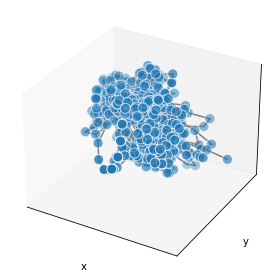

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(*node_xyz.T, s=100, ec="w")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")
def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

In [94]:
sum(list(weights.values()))

34.940425274132494